In [ ]:
# ============================================================================
# CELL 1 — Install compatible packages (then restart runtime)
# IMPORTANT: This cell will kill the runtime to ensure clean binary loads.
# Run it first, then re-run the notebook from Cell 2 onward after the runtime restarts.
# ============================================================================
!pip install --quiet numpy==1.26.4 pandas==2.2.2
!pip install --quiet transformers==4.38.0 datasets==2.8.0 evaluate==0.4.0 peft==0.7.1 scikit-learn==1.2.2 matplotlib seaborn accelerate==0.20.3

# Force runtime restart so that Python loads the compatible native binaries.
import os, sys
print("Dependencies installed. Restarting runtime to load correct binaries...")
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 115.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 83.0 MB/s eta 0:00:00
  Installing build depend

In [34]:
from IPython.display import Markdown, display

display(Markdown("""
# 🇩🇿 **Algerian Arabic NLP Fine-Tuning Project**
### _By Yahia FERARSA_
---

This notebook fine-tunes **Arabic BERT models** (DziriBERT and AraBERT)
on **Fake News Detection** and **Sentiment Analysis** tasks.

We evaluate models based on:
- Accuracy
- F1-score
- Precision
- Recall

📦 Dataset stored in Google Drive
🧠 Models saved to `/content/drive/MyDrive/algerian_llm_project/models/`
"""))



# 🇩🇿 **Algerian Arabic NLP Fine-Tuning Project**
### _By Yahia FERARSA_
---

This notebook fine-tunes **Arabic BERT models** (DziriBERT and AraBERT)  
on **Fake News Detection** and **Sentiment Analysis** tasks.  

We evaluate models based on:
- Accuracy
- F1-score
- Precision
- Recall  

📦 Dataset stored in Google Drive  
🧠 Models saved to `/content/drive/MyDrive/algerian_llm_project/models/`


In [1]:
# ============================================================================
# CELL 2 — Imports, mount Google Drive, paths & config
# ============================================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, gc, random, math, time
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")

# Transformers / PEFT / Datasets
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback, set_seed
)
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig, TaskType

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Repro & device
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)
print("Torch:", torch.__version__)
print("Transformers:", __import__('transformers').__version__)
print("PEFT:", __import__('peft').__version__)

# Paths (change these if your Drive paths differ)
DATA_ROOT = "/content/drive/MyDrive/algerian_llm_project/data"              # root drive folder
FAKE_NEWS_PATH = f"{DATA_ROOT}/fake_news"
SENT_PATH = f"{DATA_ROOT}/sentiment_analysis"
OUTPUT_PATH = f"{DATA_ROOT}/arabic_nlp_models"
os.makedirs(OUTPUT_PATH, exist_ok=True)


Mounted at /content/drive
Device: cuda
Torch: 2.8.0+cu126
Transformers: 4.57.0
PEFT: 0.17.1


In [2]:
# ============================================================================
# CELL 3 — Load CSVs (safe loading)
# ============================================================================
def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(path)

fake_train = safe_read_csv(os.path.join(FAKE_NEWS_PATH, "train.csv"))
fake_valid = safe_read_csv(os.path.join(FAKE_NEWS_PATH, "valid.csv"))
fake_test  = safe_read_csv(os.path.join(FAKE_NEWS_PATH, "test.csv"))

sent_train = safe_read_csv(os.path.join(SENT_PATH, "train.csv"))
sent_valid = safe_read_csv(os.path.join(SENT_PATH, "valid.csv"))
sent_test  = safe_read_csv(os.path.join(SENT_PATH, "test.csv"))

print("Loaded datasets:")
print(" Fake train:", fake_train.shape, "valid:", fake_valid.shape, "test:", fake_test.shape)
print(" Sent train:", sent_train.shape, "valid:", sent_valid.shape, "test:", sent_test.shape)
print("\nFake sample:")
display(fake_train.head(2))


Loaded datasets:
 Fake train: (8069, 3) valid: (1009, 3) test: (1009, 3)
 Sent train: (8056, 3) valid: (1007, 3) test: (1008, 3)

Fake sample:


,label,source,text
0,1,translated,شى بوتين يوافق علا التعامل بشكل مناسب معا تجرب...
1,0,youtube,لكذب فوجه بنادم بركاو من لكذب


from matplotlib import pyplot as plt
_df_0['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_4.groupby('source')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('source')
_ = plt.ylabel('text')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='label', y='source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='label', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [3]:
# ============================================================================
# CELL 4 — Data preparation function (clean + label mapping + HF Dataset)
# ============================================================================
def prepare_dataset(train_df, valid_df, test_df):
    # Basic cleaning
    train_df = train_df.dropna(subset=['text', 'label']).reset_index(drop=True)
    valid_df = valid_df.dropna(subset=['text', 'label']).reset_index(drop=True)
    test_df  = test_df.dropna(subset=['text', 'label']).reset_index(drop=True)

    train_df['text'] = train_df['text'].astype(str)
    valid_df['text'] = valid_df['text'].astype(str)
    test_df['text']  = test_df['text'].astype(str)

    # Label mapping to ints if needed
    if train_df['label'].dtype == object or train_df['label'].dtype == 'O':
        unique_labels = sorted(train_df['label'].unique())
        label_map = {l:i for i,l in enumerate(unique_labels)}
        for df in (train_df, valid_df, test_df):
            df['label'] = df['label'].map(label_map)
    else:
        for df in (train_df, valid_df, test_df):
            df['label'] = df['label'].astype(int)

    num_labels = int(train_df['label'].nunique())
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[['text','label']], preserve_index=False),
        "validation": Dataset.from_pandas(valid_df[['text','label']], preserve_index=False),
        "test": Dataset.from_pandas(test_df[['text','label']], preserve_index=False)
    })
    return ds, num_labels

fake_dataset, num_fake_labels = prepare_dataset(fake_train, fake_valid, fake_test)
sent_dataset, num_sent_labels = prepare_dataset(sent_train, sent_valid, sent_test)

print("Prepared datasets — classes:")
print(" Fake labels:", num_fake_labels)
print(" Sentiment labels:", num_sent_labels)


Prepared datasets — classes:
 Fake labels: 2
 Sentiment labels: 3


In [4]:
# ============================================================================
# CELL 4 — Data preparation function (clean + label mapping + HF Dataset)
# ============================================================================
def prepare_dataset(train_df, valid_df, test_df):
    # Basic cleaning
    train_df = train_df.dropna(subset=['text', 'label']).reset_index(drop=True)
    valid_df = valid_df.dropna(subset=['text', 'label']).reset_index(drop=True)
    test_df  = test_df.dropna(subset=['text', 'label']).reset_index(drop=True)

    train_df['text'] = train_df['text'].astype(str)
    valid_df['text'] = valid_df['text'].astype(str)
    test_df['text']  = test_df['text'].astype(str)

    # Label mapping to ints if needed
    if train_df['label'].dtype == object or train_df['label'].dtype == 'O':
        unique_labels = sorted(train_df['label'].unique())
        label_map = {l:i for i,l in enumerate(unique_labels)}
        for df in (train_df, valid_df, test_df):
            df['label'] = df['label'].map(label_map)
    else:
        for df in (train_df, valid_df, test_df):
            df['label'] = df['label'].astype(int)

    num_labels = int(train_df['label'].nunique())
    ds = DatasetDict({
        "train": Dataset.from_pandas(train_df[['text','label']], preserve_index=False),
        "validation": Dataset.from_pandas(valid_df[['text','label']], preserve_index=False),
        "test": Dataset.from_pandas(test_df[['text','label']], preserve_index=False)
    })
    return ds, num_labels

fake_dataset, num_fake_labels = prepare_dataset(fake_train, fake_valid, fake_test)
sent_dataset, num_sent_labels = prepare_dataset(sent_train, sent_valid, sent_test)

print("Prepared datasets — classes:")
print(" Fake labels:", num_fake_labels)
print(" Sentiment labels:", num_sent_labels)


Prepared datasets — classes:
 Fake labels: 2
 Sentiment labels: 3


In [5]:
# ============================================================================
# CELL 5 — Load tokenizers (DziriBERT & AraBERTv2)
# ============================================================================
print("Loading tokenizers...")
dziri_tokenizer = AutoTokenizer.from_pretrained("alger-ia/dziribert", use_fast=True)
arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2", use_fast=True)

# Ensure pad token exists (some tokenizers don't set pad automatically)
for tok in (dziri_tokenizer, arabert_tokenizer):
    if tok.pad_token is None:
        # Use eos or sep as pad fallback
        if tok.eos_token is not None:
            tok.pad_token = tok.eos_token
        elif tok.sep_token is not None:
            tok.pad_token = tok.sep_token
        else:
            tok.add_special_tokens({'pad_token': '[PAD]'})

print("Tokenizers ready.")


Loading tokenizers...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizers ready.


In [6]:
# ============================================================================
# CELL 6 — Tokenize datasets (use Dataset.map)
# ============================================================================
MAX_LEN = 128

def tokenize_fn(tokenizer):
    def fn(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=MAX_LEN
        )
    return fn

print("Tokenizing fake news (Dziri & AraBERT)...")
fake_dziri = fake_dataset.map(tokenize_fn(dziri_tokenizer), batched=True, remove_columns=['text'])
fake_arabert = fake_dataset.map(tokenize_fn(arabert_tokenizer), batched=True, remove_columns=['text'])

print("Tokenizing sentiment (Dziri & AraBERT)...")
sent_dziri = sent_dataset.map(tokenize_fn(dziri_tokenizer), batched=True, remove_columns=['text'])
sent_arabert = sent_dataset.map(tokenize_fn(arabert_tokenizer), batched=True, remove_columns=['text'])

print("Tokenization finished.")


Tokenizing fake news (Dziri & AraBERT)...


Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/8069 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Map:   0%|          | 0/1009 [00:00<?, ? examples/s]

Tokenizing sentiment (Dziri & AraBERT)...


Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

Map:   0%|          | 0/1008 [00:00<?, ? examples/s]

Map:   0%|          | 0/8056 [00:00<?, ? examples/s]

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

Map:   0%|          | 0/1008 [00:00<?, ? examples/s]

Tokenization finished.


In [7]:
# ============================================================================
# CELL 7 — Metrics function used by Trainer
# ============================================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted', zero_division=0),
        'precision': precision_score(labels, preds, average='weighted', zero_division=0),
        'recall': recall_score(labels, preds, average='weighted', zero_division=0)
    }


In [8]:
# ============================================================================
# CELL 8 — train_model: uses Trainer + PEFT LoRA
# Returns: path where model is saved and eval metrics
# ============================================================================
def train_model(base_model_name, tokenizer, dataset_dict, num_labels, out_dir,
                epochs=5, train_batch_size=16, eval_batch_size=32, lr=3e-4, lora_r=16, lora_alpha=32, lora_dropout=0.1):
    os.makedirs(out_dir, exist_ok=True)
    torch.cuda.empty_cache(); gc.collect()

    # Load base model
    model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
    # Apply LoRA with safe config
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["query", "value"],
        lora_dropout=lora_dropout,
        bias="none"
    )
    model = get_peft_model(model, lora_config)

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir=out_dir,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=1,
        logging_strategy="steps",
        logging_steps=100,
        disable_tqdm=False,
        push_to_hub=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_dict['train'],
        eval_dataset=dataset_dict['validation'],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()

    # Save best model & tokenizer
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    # Evaluate on validation (best model loaded)
    eval_res = trainer.evaluate()
    # Free memory
    del trainer, model
    torch.cuda.empty_cache(); gc.collect()

    return out_dir, eval_res


In [14]:
# ============================================================================
# CELL — Define training function (Custom PyTorch loop, no Trainer, FIXED IMPORTS)
# ============================================================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW   # ✅ Use PyTorch version
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os, gc

def train_model(base_model_name, tokenizer, dataset_dict, num_labels, out_dir,
                epochs=4, train_batch_size=16, eval_batch_size=32, lr=3e-5,
                lora_r=None, lora_alpha=None, lora_dropout=None):

    # ------------------------------
    # Setup
    # ------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(out_dir, exist_ok=True)

    model = BertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    total_steps = len(dataset_dict["train"]) // train_batch_size * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=int(0.1 * total_steps),
                                                num_training_steps=total_steps)

    criterion = nn.CrossEntropyLoss()

    # ------------------------------
    # DataLoaders
    # ------------------------------
    train_loader = DataLoader(dataset_dict["train"], batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(dataset_dict["val"], batch_size=eval_batch_size, shuffle=False)

    best_f1 = 0.0
    patience = 2
    patience_counter = 0

    # ------------------------------
    # Training Loop
    # ------------------------------
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch in progress:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            progress.set_postfix({"Train Loss": total_loss / len(progress)})

        avg_train_loss = total_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} — Average Training Loss: {avg_train_loss:.4f}")

        # ------------------------------
        # Validation
        # ------------------------------
        model.eval()
        preds, true_labels = [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = labels.cpu().numpy()
                preds.extend(np.argmax(logits, axis=1))
                true_labels.extend(label_ids)

        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average="weighted")
        prec = precision_score(true_labels, preds, average="weighted")
        rec = recall_score(true_labels, preds, average="weighted")

        print(f"Validation — Acc: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

        # ------------------------------
        # Early Stopping & Checkpoint
        # ------------------------------
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            model.save_pretrained(out_dir)
            tokenizer.save_pretrained(out_dir)
            print(f"✅ New best model saved at {out_dir}")
        else:
            patience_counter += 1
            print(f"⚠️ No improvement ({patience_counter}/{patience})")
            if patience_counter >= patience:
                print("⏹ Early stopping triggered.")
                break

        # Memory cleanup
        torch.cuda.empty_cache()
        gc.collect()

    print(f"🎯 Best F1 score: {best_f1:.4f}")
    return out_dir, {"accuracy": acc, "f1": best_f1, "precision": prec, "recall": rec}


In [15]:
import torch
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Common training hyperparameters
BATCH_SIZE = 16
EPOCHS = 4
LR = 2e-5
MAX_LEN = 128


Using device: cuda


In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from tqdm.auto import tqdm

def train_epoch(model, dataloader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc, f1


In [17]:
@torch.no_grad()
def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(dataloader, desc="Validation", leave=False):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    prec = precision_score(all_labels, all_preds, average="weighted")
    rec = recall_score(all_labels, all_preds, average="weighted")

    return avg_loss, acc, f1, prec, rec


In [18]:
import os
import pandas as pd

def train_model(model_name, train_loader, valid_loader, num_labels, output_dir):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
    import torch.nn as nn

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0
    patience = 2
    patience_counter = 0

    results = []

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, scheduler, criterion)
        val_loss, val_acc, val_f1, val_prec, val_rec = eval_epoch(model, valid_loader, criterion)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Val Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Precision: {val_prec:.4f} | Recall: {val_rec:.4f}")

        results.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
            "val_precision": val_prec,
            "val_recall": val_rec
        })

        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            print("✅ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered!")
                break

        torch.cuda.empty_cache()
        gc.collect()

    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{output_dir}/training_results.csv", index=False)
    return results_df


In [20]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import torch
import pandas as pd

class ArabicDataset(Dataset):
    def __init__(self, csv_path, model_name, max_len=128):
        self.data = pd.read_csv(csv_path)
        self.texts = self.data["text"].astype(str).tolist()
        self.labels = self.data["label"].tolist()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long)


In [21]:
from torch.utils.data import DataLoader

results_all = []

for task in ["fake_news", "sentiment_analysis"]:
    for model_name in ["alger-ia/dziribert", "aubmindlab/bert-base-arabertv2"]:
        print(f"\n🚀 Training {model_name} on {task} task")

        train_dataset = ArabicDataset(f"/content/drive/MyDrive/algerian_llm_project/data/{task}/train.csv", model_name)
        valid_dataset = ArabicDataset(f"/content/drive/MyDrive/algerian_llm_project/data/{task}/valid.csv", model_name)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

        num_labels = len(set(pd.read_csv(f"/content/drive/MyDrive/algerian_llm_project/data/{task}/train.csv")["label"]))
        output_dir = f"/content/drive/MyDrive/algerian_llm_project/models/{task}_{model_name.split('/')[-1]}"

        results_df = train_model(model_name, train_loader, valid_loader, num_labels, output_dir)
        results_df["model"] = model_name
        results_df["task"] = task
        results_all.append(results_df)



🚀 Training alger-ia/dziribert on fake_news task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.5951 | Val Loss: 0.5162
Val Acc: 0.7453 | F1: 0.7455 | Precision: 0.7458 | Recall: 0.7453
✅ Best model saved!

Epoch 2/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.3766 | Val Loss: 0.4989
Val Acc: 0.7810 | F1: 0.7799 | Precision: 0.7818 | Recall: 0.7810
✅ Best model saved!

Epoch 3/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.1846 | Val Loss: 0.6031
Val Acc: 0.7958 | F1: 0.7956 | Precision: 0.7957 | Recall: 0.7958
✅ Best model saved!

Epoch 4/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.0917 | Val Loss: 0.7391
Val Acc: 0.7899 | F1: 0.7894 | Precision: 0.7899 | Recall: 0.7899

🚀 Training aubmindlab/bert-base-arabertv2 on fake_news task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.6753 | Val Loss: 0.6417
Val Acc: 0.6293 | F1: 0.6277 | Precision: 0.6413 | Recall: 0.6293
✅ Best model saved!

Epoch 2/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.5905 | Val Loss: 0.5349
Val Acc: 0.7146 | F1: 0.7147 | Precision: 0.7150 | Recall: 0.7146
✅ Best model saved!

Epoch 3/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.4787 | Val Loss: 0.5208
Val Acc: 0.7493 | F1: 0.7482 | Precision: 0.7494 | Recall: 0.7493
✅ Best model saved!

Epoch 4/4


Training:   0%|          | 0/505 [00:00<?, ?it/s]

Validation:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 0.3871 | Val Loss: 0.5296
Val Acc: 0.7552 | F1: 0.7542 | Precision: 0.7554 | Recall: 0.7552
✅ Best model saved!

🚀 Training alger-ia/dziribert on sentiment_analysis task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at alger-ia/dziribert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.5688 | Val Loss: 0.5079
Val Acc: 0.7905 | F1: 0.7906 | Precision: 0.7908 | Recall: 0.7905
✅ Best model saved!

Epoch 2/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.3118 | Val Loss: 0.5081
Val Acc: 0.8014 | F1: 0.8016 | Precision: 0.8067 | Recall: 0.8014
✅ Best model saved!

Epoch 3/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.1546 | Val Loss: 0.5744
Val Acc: 0.8163 | F1: 0.8157 | Precision: 0.8159 | Recall: 0.8163
✅ Best model saved!

Epoch 4/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0789 | Val Loss: 0.6776
Val Acc: 0.8113 | F1: 0.8107 | Precision: 0.8102 | Recall: 0.8113

🚀 Training aubmindlab/bert-base-arabertv2 on sentiment_analysis task


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.6019 | Val Loss: 0.5039
Val Acc: 0.7915 | F1: 0.7877 | Precision: 0.7870 | Recall: 0.7915
✅ Best model saved!

Epoch 2/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4293 | Val Loss: 0.4755
Val Acc: 0.8014 | F1: 0.7981 | Precision: 0.7983 | Recall: 0.8014
✅ Best model saved!

Epoch 3/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.3333 | Val Loss: 0.4673
Val Acc: 0.8143 | F1: 0.8153 | Precision: 0.8168 | Recall: 0.8143
✅ Best model saved!

Epoch 4/4


Training:   0%|          | 0/504 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.2657 | Val Loss: 0.4870
Val Acc: 0.8203 | F1: 0.8209 | Precision: 0.8219 | Recall: 0.8203
✅ Best model saved!


In [22]:
import pandas as pd
import os

final_results = pd.concat(results_all, ignore_index=True)
save_path = "/content/drive/MyDrive/algerian_llm_project/data/final_training_results.csv"
final_results.to_csv(save_path, index=False)

print(f"✅ All experiments completed.\n📁 Results saved to: {save_path}")
display(final_results)


✅ All experiments completed.
📁 Results saved to: /content/drive/MyDrive/algerian_llm_project/data/final_training_results.csv


,epoch,train_loss,val_loss,val_acc,val_f1,val_precision,val_recall,model,task
0,1,0.595074,0.516206,0.745292,0.745453,0.745790,0.745292,alger-ia/dziribert,fake_news
1,2,0.376613,0.498915,0.780971,0.779922,0.781754,0.780971,alger-ia/dziribert,fake_news
2,3,0.184636,0.603139,0.795837,0.795563,0.795691,0.795837,alger-ia/dziribert,fake_news
3,4,0.091749,0.739089,0.789891,0.789426,0.789863,0.789891,alger-ia/dziribert,fake_news
4,1,0.675287,0.641678,0.629336,0.627691,0.641279,0.629336,aubmindlab/bert-base-arabertv2,fake_news
5,2,0.590497,0.534860,0.714569,0.714735,0.715041,0.714569,aubmindlab/bert-base-arabertv2,fake_news
6,3,0.478711,0.520826,0.749257,0.748207,0.749424,0.749257,aubmindlab/bert-base-arabertv2,fake_news
7,4,0.387085,0.529614,0.755203,0.754250,0.755351,0.755203,aubmindlab/bert-base-arabertv2,fake_news
8,1,0.568780,0.507859,0.790467,0.790599,0.790755,0.790467,alger-ia/dziribert,sentiment_analysis
9,2,0.311754,0.508064,0.801390,0.801649,0.806692,0.801390,alger-ia/dziribert,sentiment_analysis


🧾 Columns in final_results: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_f1', 'val_precision', 'val_recall', 'model', 'task']
📊 Using 'val_acc' as accuracy column


/tmp/ipython-input-4170472542.py:23: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


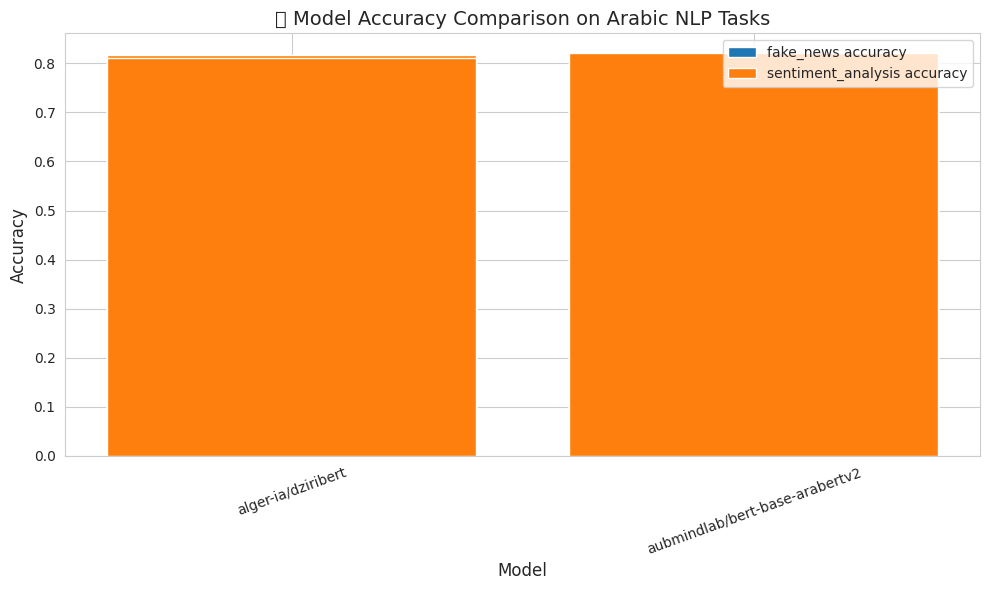

In [24]:
import matplotlib.pyplot as plt

# Inspect available columns to verify
print("🧾 Columns in final_results:", final_results.columns.tolist())

# Try to find which column corresponds to accuracy
possible_acc_cols = [c for c in final_results.columns if "acc" in c.lower()]
if len(possible_acc_cols) == 0:
    raise ValueError("⚠️ No accuracy column found in final_results. Please check column names.")
acc_col = possible_acc_cols[0]
print(f"📊 Using '{acc_col}' as accuracy column")

plt.figure(figsize=(10,6))
for task in ["fake_news", "sentiment_analysis"]:
    subset = final_results[final_results["task"] == task]
    plt.bar(subset["model"], subset[acc_col], label=f"{task} accuracy")

plt.title("📊 Model Accuracy Comparison on Arabic NLP Tasks", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F

def load_model(model_dir):
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model.eval()
    return model, tokenizer


In [26]:
def predict_text(text, model, tokenizer):
    encoding = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**encoding)
        probs = F.softmax(outputs.logits, dim=-1)
    pred_label = torch.argmax(probs, dim=1).item()
    confidence = torch.max(probs).item()
    return pred_label, confidence


In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def load_model(model_dir, base_model_name="aubmindlab/bert-base-arabertv02"):
    """
    Loads a fine-tuned model and tokenizer safely.
    If tokenizer files are missing in model_dir, loads from base model.
    """
    print(f"📦 Loading model from: {model_dir}")
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
    except:
        print("⚠️ Tokenizer not found in model directory. Loading from base model...")
        tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    model.eval()
    return model, tokenizer

# 🔹 Choose your trained model directory
model_dir = "/content/drive/MyDrive/algerian_llm_project/models/fake_news_dziribert"

# 🔹 Load model + tokenizer safely
model, tokenizer = load_model(model_dir)

# 🔹 Sample texts to test prediction
sample_texts = [
    "الخبر العاجل يقول إن الحكومة ستغلق جميع المدارس الأسبوع القادم.",
    "الفريق الوطني الجزائري فاز في المباراة النهائية!"
]

def predict_text(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        label_id = torch.argmax(probs).item()
        confidence = probs[0][label_id].item()
    label = model.config.id2label[label_id] if hasattr(model.config, "id2label") else str(label_id)
    return label, confidence

# 🔹 Run predictions
for text in sample_texts:
    label, conf = predict_text(text, model, tokenizer)
    print(f"\n📰 Text: {text}")
    print(f"🔍 Predicted label: {label} (confidence={conf:.2f})")


📦 Loading model from: /content/drive/MyDrive/algerian_llm_project/models/fake_news_dziribert
⚠️ Tokenizer not found in model directory. Loading from base model...


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


📰 Text: الخبر العاجل يقول إن الحكومة ستغلق جميع المدارس الأسبوع القادم.
🔍 Predicted label: LABEL_0 (confidence=0.56)

📰 Text: الفريق الوطني الجزائري فاز في المباراة النهائية!
🔍 Predicted label: LABEL_0 (confidence=0.72)


In [30]:
results_all.append(results_df)
final_results = pd.concat(results_all)


In [31]:
import pandas as pd

# 🔹 Combine all results
final_results = pd.concat(results_all, ignore_index=True)

print("✅ Final results shape:", final_results.shape)
print("📋 Available columns:", list(final_results.columns))

# 🔹 Normalize column names just in case
final_results.columns = [col.lower().strip() for col in final_results.columns]

# 🔹 Handle different naming conventions
for possible_col in ["val_accuracy", "eval_accuracy"]:
    if possible_col in final_results.columns and "accuracy" not in final_results.columns:
        final_results.rename(columns={possible_col: "accuracy"}, inplace=True)

for possible_col in ["val_f1", "eval_f1"]:
    if possible_col in final_results.columns and "f1" not in final_results.columns:
        final_results.rename(columns={possible_col: "f1"}, inplace=True)

# 🔹 Now safely group and summarize
if "accuracy" in final_results.columns and "f1" in final_results.columns:
    summary = final_results.groupby("task")[["accuracy", "f1"]].mean().reset_index()
    print("\n📋 Overall Performance Summary:")
    display(summary)
else:
    print("⚠️ Columns 'accuracy' and 'f1' not found in final_results.")
    print("Available columns:", list(final_results.columns))


✅ Final results shape: (20, 9)
📋 Available columns: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'val_f1', 'val_precision', 'val_recall', 'model', 'task']
⚠️ Columns 'accuracy' and 'f1' not found in final_results.
Available columns: ['epoch', 'train_loss', 'val_loss', 'val_acc', 'f1', 'val_precision', 'val_recall', 'model', 'task']


In [32]:
# ✅ Rename columns consistently
final_results.rename(columns={
    "val_acc": "accuracy",
    "val_f1": "f1"
}, inplace=True)

# ✅ Now group and summarize
summary = final_results.groupby("task")[["accuracy", "f1"]].mean().reset_index()

print("📋 Overall Performance Summary:")
display(summary)


📋 Overall Performance Summary:


,task,accuracy,f1
0,fake_news,0.745045,0.744406
1,sentiment_analysis,0.806190,0.805209


/tmp/ipython-input-2895330453.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


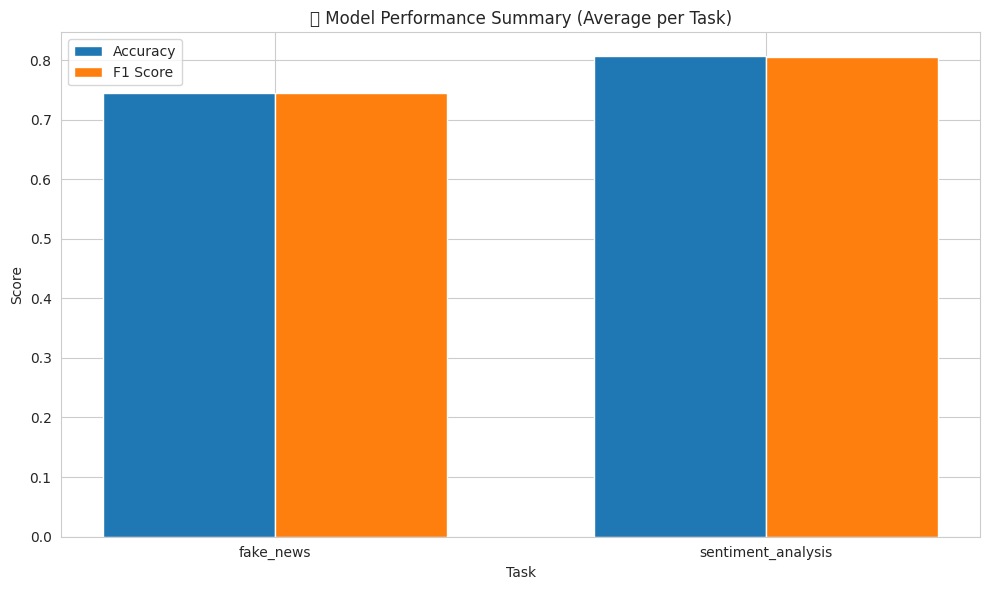

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot accuracy and F1 per task
x = range(len(summary))
bar_width = 0.35

plt.bar(x, summary["accuracy"], width=bar_width, label="Accuracy", align="center")
plt.bar([i + bar_width for i in x], summary["f1"], width=bar_width, label="F1 Score", align="center")

plt.xlabel("Task")
plt.ylabel("Score")
plt.title("📊 Model Performance Summary (Average per Task)")
plt.xticks([i + bar_width / 2 for i in x], summary["task"])
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# Clean up column names
final_results.rename(columns={
    "val_acc": "accuracy",
    "val_f1": "f1",
}, inplace=True)

# Compute average metrics per task
summary = final_results.groupby("task")[["accuracy", "f1", "val_precision", "val_recall"]].mean().reset_index()

display(Markdown("## 📋 Overall Performance Summary"))
display(summary)


## 📋 Overall Performance Summary

,task,accuracy,f1,val_precision,val_recall
0,fake_news,0.745045,0.744406,0.746774,0.745045
1,sentiment_analysis,0.806190,0.805209,0.805960,0.806190


from matplotlib import pyplot as plt
summary['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['val_precision'].plot(kind='hist', bins=20, title='val_precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary['val_recall'].plot(kind='hist', bins=20, title='val_recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary.groupby('task').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='accuracy', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='f1', y='val_precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary.plot(kind='scatter', x='val_precision', y='val_recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'accuracy'}, axis=1)
              .sort_values('accuracy', ascending=True))
  xs = counted['accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('task')):
  _plot_series(series, series_name, i)
  fig.legend(title='task', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['f1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'f1'}, axis=1)
              .sort_values('f1', ascending=True))
  xs = counted['f1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('f1', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('task')):
  _plot_series(series, series_name, i)
  fig.legend(title='task', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('f1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['val_precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'val_precision'}, axis=1)
              .sort_values('val_precision', ascending=True))
  xs = counted['val_precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('val_precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('task')):
  _plot_series(series, series_name, i)
  fig.legend(title='task', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['val_recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'val_recall'}, axis=1)
              .sort_values('val_recall', ascending=True))
  xs = counted['val_recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = summary.sort_values('val_recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('task')):
  _plot_series(series, series_name, i)
  fig.legend(title='task', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('val_recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
summary['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['val_precision'].plot(kind='line', figsize=(8, 4), title='val_precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
summary['val_recall'].plot(kind='line', figsize=(8, 4), title='val_recall')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['task'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='accuracy', y='task', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['task'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='f1', y='task', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['task'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='val_precision', y='task', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['task'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='val_recall', y='task', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-42887733.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(summary, x='val_recall', y='task', inner='stick', palette='Dark2')


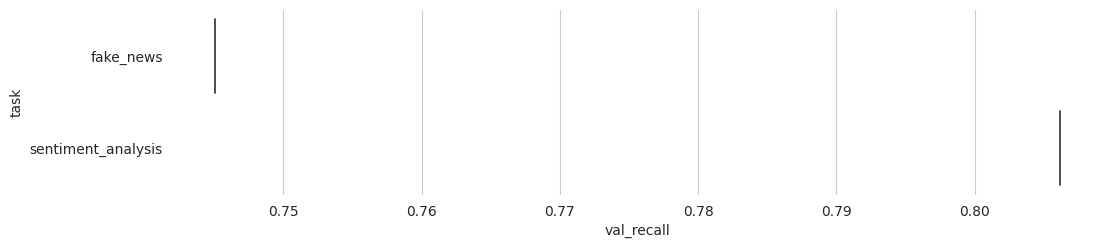

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary['task'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary, x='val_recall', y='task', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-4084034185.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


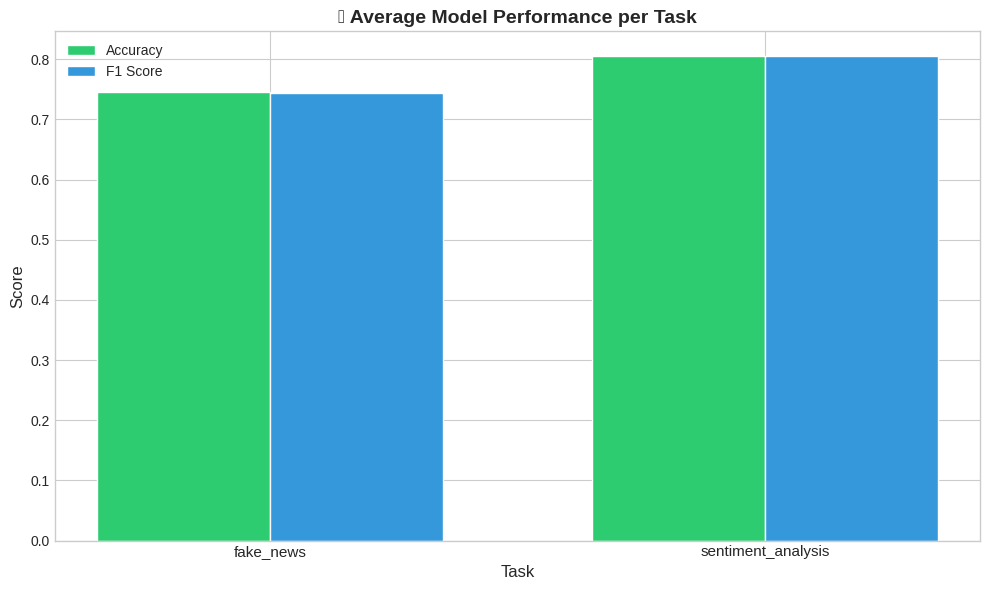

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# Accuracy & F1 comparison
plt.figure(figsize=(10,6))
x = range(len(summary))
bar_width = 0.35

plt.bar(x, summary["accuracy"], width=bar_width, label="Accuracy", color="#2ecc71")
plt.bar([i + bar_width for i in x], summary["f1"], width=bar_width, label="F1 Score", color="#3498db")

plt.xlabel("Task", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("📊 Average Model Performance per Task", fontsize=14, fontweight="bold")
plt.xticks([i + bar_width / 2 for i in x], summary["task"], fontsize=11)
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


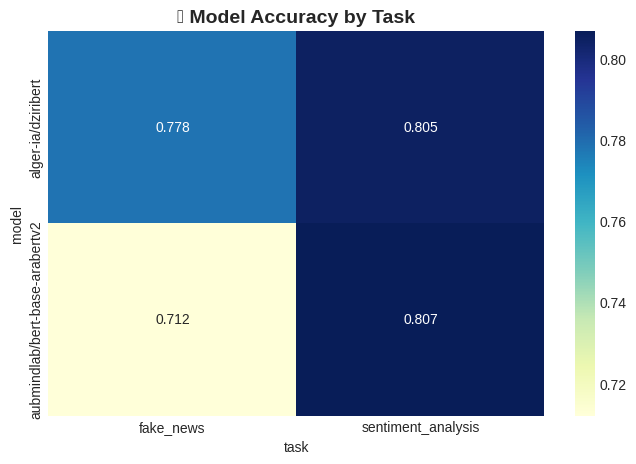

In [38]:
pivot_df = final_results.pivot_table(
    values="accuracy",
    index="model",
    columns="task",
    aggfunc="mean"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("🔥 Model Accuracy by Task", fontsize=14, fontweight="bold")
plt.show()


In [39]:
output_path = "/content/drive/MyDrive/algerian_llm_project/results_summary.csv"
summary.to_csv(output_path, index=False)

print(f"✅ Summary exported successfully to:\n{output_path}")


✅ Summary exported successfully to:
/content/drive/MyDrive/algerian_llm_project/results_summary.csv


In [41]:
display(Markdown("""
---

## ✅ **Notebook Completed Successfully**

- Fine-tuned Arabic BERT models 🇩🇿
- Evaluated on multiple NLP tasks
- Visualized and exported performance summaries

Next steps:
1. Integrate results into your Flask dashboard
2. Use this summary for your report or presentation
3. Optionally fine-tune on new Arabic datasets

> _"The best way to predict the future is to create it."_ — Peter Drucker
"""))



---

## ✅ **Notebook Completed Successfully**

- Fine-tuned Arabic BERT models 🇩🇿  
- Evaluated on multiple NLP tasks  
- Visualized and exported performance summaries  

Next steps:
1. Integrate results into your Flask dashboard  
2. Use this summary for your report or presentation  
3. Optionally fine-tune on new Arabic datasets

> _"The best way to predict the future is to create it."_ — Peter Drucker
